In [1]:
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ta
import warnings
warnings.filterwarnings('ignore')

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


In [2]:
tickers = ['EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'USDCHF=X']

In [ ]:
# Do not run
for ticker in tickers:
    ohlcv_d = yf.download(ticker, period='12y', interval="1d")
    ohlcv_w = yf.download(ticker, period='12y', interval="1wk")
    ohlcv_d.to_csv(ticker+'_12y_daily.csv')
    ohlcv_w.to_csv(ticker+'_12y_weekly.csv')

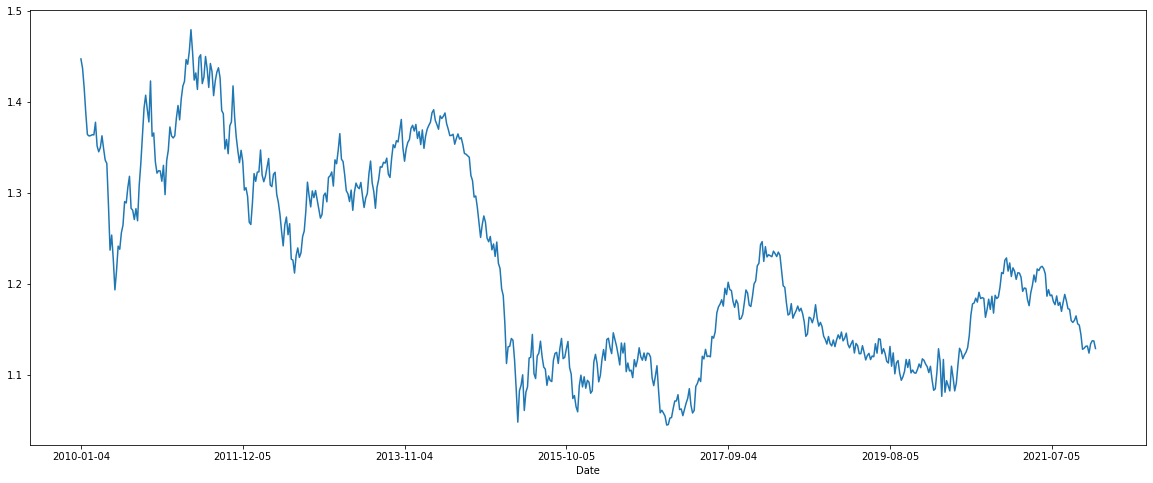

In [3]:
folder, ticker, period = 'CSVData', 'EURUSD=X', 'weekly'
ohlcv = pd.read_csv(folder+'/'+ticker+'_12y_'+period+'.csv').set_index('Date')
multiplier = 100 if 'JPY' in ticker else 10000
pyplot.figure(figsize=(20,8))
ohlcv['Close'].plot()
pyplot.show()

In [4]:
ohlcv['Median'] = (ohlcv['High'] + ohlcv['Low'])/2
ohlcv

,Open,High,Low,Close,Adj Close,Volume,Median
Date,,,,,,,
2010-01-04,1.431004,1.448310,1.426208,1.447011,1.447011,0,1.437259
2010-01-11,1.446487,1.457705,1.434103,1.436906,1.436906,0,1.445904
2010-01-18,1.437236,1.441400,1.403095,1.415388,1.415388,0,1.422248
2010-01-25,1.415408,1.419426,1.385406,1.387694,1.387694,0,1.402416
2010-02-01,1.387598,1.402406,1.358806,1.363996,1.363996,0,1.380606
...,...,...,...,...,...,...,...
2021-12-13,1.131119,1.136364,1.123962,1.123962,1.123962,0,1.130163
2021-12-20,1.124252,1.134559,1.123734,1.134173,1.134173,0,1.129147
2021-12-27,1.132387,1.137915,1.127536,1.137527,1.137527,0,1.132725


In [ ]:
# optional
# ohlcv = ohlcv[ohlcv.index > '2017-01-01']
# ohlcv

In [5]:
def timeseries_df(X, label, n):
    
    df = X[[label]]
  
    for i in range(n):
        df[label+'_'+str(i+1)] = df[label].shift(periods=i+1)
    
    df = df.drop([label], axis=1)
    df.index = X.index
    df = df.iloc[n:]
    
    return df

In [50]:
##
label = 'Close'
n = 8
X = timeseries_df(ohlcv, label, n)
y = ohlcv[[label]].iloc[n:]
##

In [ ]:
rsi14  = ta.momentum.rsi(ohlcv[label], window=14, fillna=False)
mv3 = ohlcv[label].rolling(window=3).mean().shift(periods=1)
mv5 = ohlcv[label].rolling(window=5).mean().shift(periods=1)
mv8 = ohlcv[label].rolling(window=8).mean().shift(periods=1)
mv20 = ohlcv[label].rolling(window=20).mean().shift(periods=1)

In [ ]:
X = pd.concat([mv3, mv8, mv20], axis=1)[n:]
y = ohlcv[[label]].iloc[n:]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [52]:
regr = MLPRegressor(hidden_layer_sizes=[500, 200], 
                    max_iter=1000, n_iter_no_change=500, verbose=False)
regr.fit(X_train, y_train.to_numpy().ravel())

predicted = regr.predict(X_test)

diff = predicted - y_test[label]
diff_df = pd.DataFrame({'Actual': y_test[label], 
                        'Predicted': predicted,
                        'Difference': diff})

mean_absolute_error(predicted, y_test), mean_absolute_percentage_error(predicted, y_test)

(0.008697178425214704, 0.00756891762912517)

In [53]:
ohlcv_test = ohlcv[ohlcv.index.isin(X_test.index)]
print('Average candle range: ' + str(sum(abs(ohlcv_test['High']-ohlcv_test['Low']))*multiplier/len(diff)) + ' pips')
ohlcv_test

Average candle range: 159.19840143572904 pips


,Open,High,Low,Close,Adj Close,Volume,Median
Date,,,,,,,
2019-09-02,1.099094,1.113400,1.093040,1.113400,1.113400,0,1.103220
2019-09-09,1.102074,1.115822,1.092956,1.115797,1.115797,0,1.104389
2019-09-16,1.108414,1.108426,1.099288,1.102001,1.102001,0,1.103857
2019-09-23,1.101953,1.102803,1.090584,1.094116,1.094116,0,1.096694
2019-09-30,1.094164,1.099832,1.088151,1.097996,1.097996,0,1.093991
...,...,...,...,...,...,...,...
2021-12-13,1.131119,1.136364,1.123962,1.123962,1.123962,0,1.130163
2021-12-20,1.124252,1.134559,1.123734,1.134173,1.134173,0,1.129147
2021-12-27,1.132387,1.137915,1.127536,1.137527,1.137527,0,1.132725


In [ ]:
plt.plot(abs(diff)*multiplier)

In [ ]:
ohlcv['candleRange'] = np.nan
for i in range(0,len(ohlcv)):
    ohlcv['candleRange'][i] = (ohlcv['High'][i] - ohlcv['Low'][i])*10E3
    
#print(np.nansum(ohlcv['candleRange'])/len(ohlcv['candleRange']))
print(np.nansum(ohlcv['candleRange'].mean()))
print(np.nansum(ohlcv['candleRange'].std()))
plt.figure(figsize=(20,8))
ohlcv['candleRange'].plot()

In [ ]:
regr = XGBRegressor(n_estimators=300, max_depth=6)
regr.fit(X_train, y_train.to_numpy().ravel())

predicted = regr.predict(X_test)

diff = predicted - y_test[label]
diff_df = pd.DataFrame({'Actual': y_test[label], 
                        'Predicted': predicted,
                        'Difference': diff})

print('Average diff: ' + str(sum(abs(diff))*multiplier/len(diff)) + ' pips')

In [ ]:
regr = RandomForestRegressor(n_estimators = 200)
regr.fit(X_train, y_train.to_numpy().ravel())

predicted = regr.predict(X_test)

diff = predicted - y_test[label]
diff_df = pd.DataFrame({'Actual': y_test[label], 
                        'Predicted': predicted,
                        'Difference': diff})

print('Average diff: ' + str(sum(abs(diff))*multiplier/len(diff)) + ' pips')

In [54]:
y_pred = pd.DataFrame(index = ohlcv_test.index)
y_pred['y_pred'] = predicted
y_pred['low'], y_pred['high'] = ohlcv_test['Low'], ohlcv_test['High']
y_pred['open'], y_pred['close'] = ohlcv_test['Open'], ohlcv_test['Close'] 
y_pred['hit'], y_pred['direction'], y_pred['OR'], y_pred['pips']  = np.nan, np.nan, np.nan, np.nan

In [55]:
for index, row in y_pred.iterrows():
    if y_pred['y_pred'][index] >= y_pred['low'][index] and y_pred['y_pred'][index] <= y_pred['high'][index]:
        y_pred['hit'][index] = True
    else:
        y_pred['hit'][index] = False
sum(y_pred['hit'])/len(y_pred['hit'])

0.7258064516129032

In [56]:
y_pred

,y_pred,low,high,open,close,hit,direction,OR,pips
Date,,,,,,,,,
2019-09-02,1.109467,1.093040,1.113400,1.099094,1.113400,True,NaN,NaN,NaN
2019-09-09,1.113498,1.092956,1.115822,1.102074,1.115797,True,NaN,NaN,NaN
2019-09-16,1.116739,1.099288,1.108426,1.108414,1.102001,False,NaN,NaN,NaN
2019-09-23,1.107869,1.090584,1.102803,1.101953,1.094116,False,NaN,NaN,NaN
2019-09-30,1.100880,1.088151,1.099832,1.094164,1.097996,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-12-13,1.133228,1.123962,1.136364,1.131119,1.123962,True,NaN,NaN,NaN
2021-12-20,1.128511,1.123734,1.134559,1.124252,1.134173,True,NaN,NaN,NaN
2021-12-27,1.133724,1.127536,1.137915,1.132387,1.137527,True,NaN,NaN,NaN


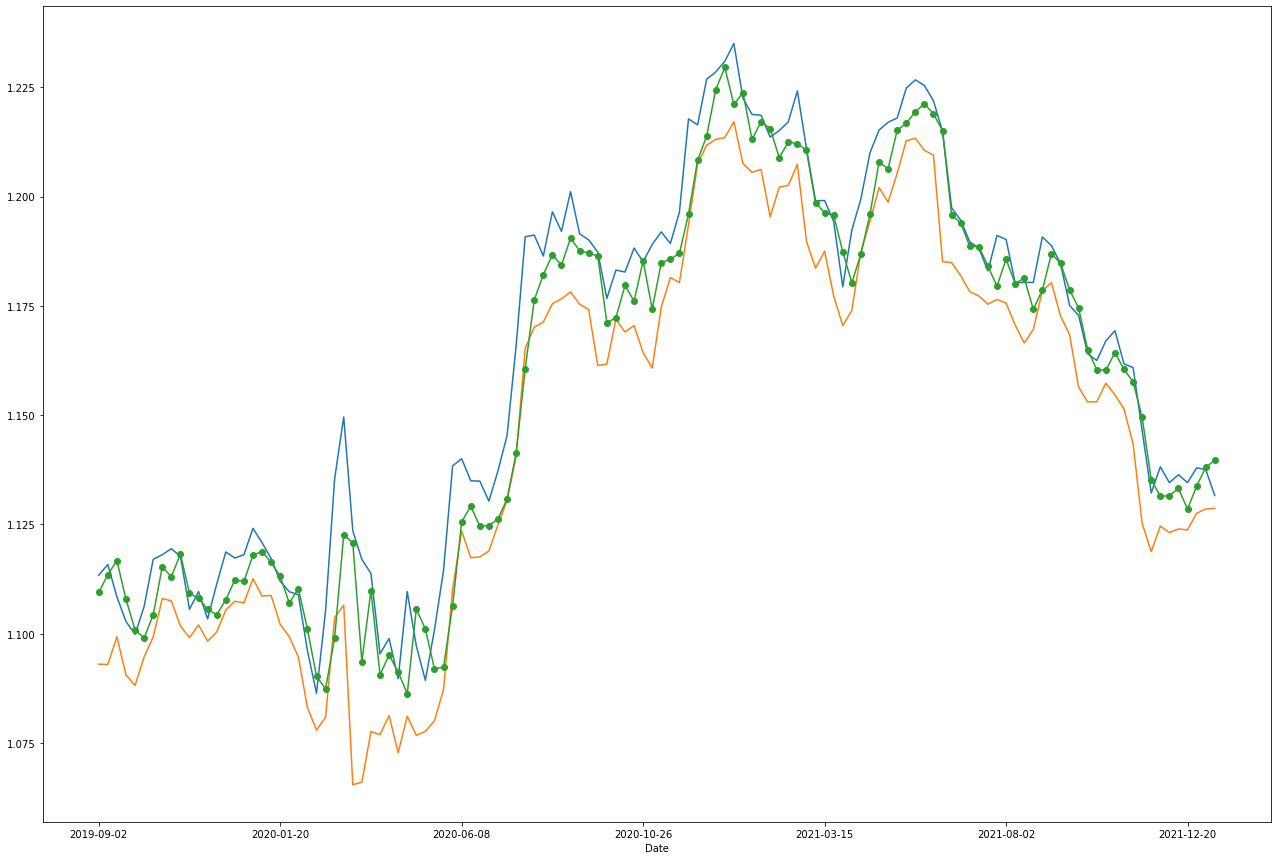

In [66]:
pyplot.figure(figsize=(22,15))
y_pred['high'].plot()
y_pred['low'].plot()
y_pred['y_pred'].plot(marker = 'o')
pyplot.show()

In [58]:
for index, row in y_pred.iterrows():
    if y_pred['y_pred'][index] >= y_pred['open'][index] and y_pred['close'][index] >= y_pred['open'][index]:
        y_pred['direction'][index] = True
    elif y_pred['y_pred'][index] <= y_pred['open'][index] and y_pred['close'][index] <= y_pred['open'][index]:
        y_pred['direction'][index] = True
    else:
        y_pred['direction'][index] = False
sum(y_pred['direction'])/len(y_pred['direction'])

0.5564516129032258

In [59]:
for index, row in y_pred.iterrows():
    if y_pred['hit'][index] == True or y_pred['direction'][index] == True:
        y_pred['OR'][index] = True
    else:
        y_pred['OR'][index] = False
sum(y_pred['OR'])/len(y_pred['OR'])

0.7661290322580645

In [60]:
for index, row in y_pred.iterrows():
    if y_pred['hit'][index] == True:
        y_pred['pips'][index] = abs(y_pred['y_pred'][index] - y_pred['open'][index])*multiplier
    elif y_pred['hit'][index] == False and y_pred['direction'][index] == True:
        y_pred['pips'][index] = abs(y_pred['close'][index] - y_pred['open'][index])*multiplier
    else:
        y_pred['pips'][index] = abs(y_pred['close'][index] - y_pred['open'][index])*-multiplier

In [61]:
y_pred

,y_pred,low,high,open,close,hit,direction,OR,pips
Date,,,,,,,,,
2019-09-02,1.109467,1.093040,1.113400,1.099094,1.113400,True,True,True,103.727072
2019-09-09,1.113498,1.092956,1.115822,1.102074,1.115797,True,True,True,114.237240
2019-09-16,1.116739,1.099288,1.108426,1.108414,1.102001,False,False,False,-64.127445
2019-09-23,1.107869,1.090584,1.102803,1.101953,1.094116,False,False,False,-78.368187
2019-09-30,1.100880,1.088151,1.099832,1.094164,1.097996,False,True,True,38.325787
...,...,...,...,...,...,...,...,...,...
2021-12-13,1.133228,1.123962,1.136364,1.131119,1.123962,True,False,True,21.086710
2021-12-20,1.128511,1.123734,1.134559,1.124252,1.134173,True,True,True,42.585270
2021-12-27,1.133724,1.127536,1.137915,1.132387,1.137527,True,True,True,13.367417


In [62]:
sum(y_pred['pips'])

646.8021959570812

In [63]:
sum(y_pred[y_pred['pips']>=0]['pips'])

3261.2228483466215

In [ ]:
y_pred['pips'].to_list()

In [ ]:
#next: test keeping false positions open